# Twitter Sentiment Analysis - Data Exploration

This notebook performs comprehensive exploratory data analysis on the Sentiment140 dataset.

## Dataset Information
- **Source**: Sentiment140 dataset
- **Size**: 1.6 million tweets
- **Labels**: Binary sentiment (0=negative, 4=positive)
- **Format**: CSV with columns: sentiment, tweet_id, date, query, username, tweet_text

## Objectives
1. Load and examine the dataset structure
2. Analyze sentiment distribution
3. Explore text characteristics
4. Identify data quality issues
5. Visualize key patterns and insights


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from textblob import TextBlob
import os

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")


Libraries imported successfully!
Current working directory: C:\Users\acer\Desktop\ml_proj\notebooks


In [ ]:
# Load the dataset
print("Loading Sentiment140 dataset...")

# Define column names based on Sentiment140 format
columns = ['sentiment', 'tweet_id', 'date', 'query', 'username', 'tweet_text']

# Load a small subset for fast processing (20k tweets for laptop-friendly processing)
# IMPORTANT: The dataset is ordered (negatives first, then positives)
# We need to sample from both sections to get balanced classes
SAMPLE_SIZE = 20000
print(f"Loading {SAMPLE_SIZE:,} tweets for analysis...")
print("Note: Sampling from both negative and positive sections to ensure balanced classes...")

# Strategy: Load samples from both halves of the dataset
# Sentiment140 has ~800k negatives (sentiment=0) followed by ~800k positives (sentiment=4)
half_sample = SAMPLE_SIZE // 2

# Load from negative section (sample from first 400k rows to save memory)
print("Loading negative samples from first half...")
df_neg_all = pd.read_csv('../sentiment140.csv', header=None, names=columns, encoding='latin-1', 
                         nrows=400000)
df_neg = df_neg_all[df_neg_all['sentiment'] == 0].sample(n=half_sample, random_state=42).reset_index(drop=True)
del df_neg_all

# Load from positive section (sample from positive region, starting at row 800k)
print("Loading positive samples from second half...")
df_pos_all = pd.read_csv('../sentiment140.csv', header=None, names=columns, encoding='latin-1', 
                         skiprows=800000, nrows=400000)
df_pos = df_pos_all[df_pos_all['sentiment'] == 4].sample(n=half_sample, random_state=42).reset_index(drop=True)
del df_pos_all

# Combine both and shuffle
df = pd.concat([df_neg, df_pos], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
del df_neg, df_pos  # Free memory

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nSample data:")
print(df.head())

# Check data types
print("\nData types:")
print(df.dtypes)


Loading Sentiment140 dataset...
Loading 20,000 tweets for analysis...
Dataset loaded successfully!
Shape: (20000, 6)

Sample data:
   sentiment    tweet_id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

          username  \
0  _TheSpecialOne_   
1    scotthamilton   
2         mattycus   
3          ElleCTF   
4           Karoli   

                                                                                            tweet_text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Thi...  
1  is upset that he can't update his Facebook by texting it... and might cry as a result  School to...  
2           

In [3]:
# Dataset already loaded in previous cell (20k sample)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Dataset shape: (20000, 6)
Memory usage: 6.33 MB


In [4]:
# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Total tweets: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Check for missing values
print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
print(missing_values)

# Check for duplicates
print(f"\n=== DUPLICATES ===")
print(f"Duplicate tweets: {df.duplicated(subset=['tweet_text']).sum():,}")
print(f"Duplicate tweet IDs: {df.duplicated(subset=['tweet_id']).sum():,}")


=== DATASET OVERVIEW ===
Total tweets: 20,000
Columns: ['sentiment', 'tweet_id', 'date', 'query', 'username', 'tweet_text']
Date range: Fri Apr 17 20:30:31 PDT 2009 to Tue Apr 07 08:46:10 PDT 2009

=== MISSING VALUES ===
sentiment     0
tweet_id      0
date          0
query         0
username      0
tweet_text    0
dtype: int64

=== DUPLICATES ===
Duplicate tweets: 88
Duplicate tweet IDs: 0


In [5]:
# Sentiment distribution analysis
print("=== SENTIMENT DISTRIBUTION ===")
sentiment_counts = df['sentiment'].value_counts().sort_index()
print(sentiment_counts)

# Convert sentiment labels for better understanding
sentiment_mapping = {0: 'Negative', 4: 'Positive'}
df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)

# Calculate percentages
sentiment_percentages = df['sentiment_label'].value_counts(normalize=True) * 100
print("\nSentiment percentages:")
for label, pct in sentiment_percentages.items():
    print(f"{label}: {pct:.2f}%")


=== SENTIMENT DISTRIBUTION ===
sentiment
0    20000
Name: count, dtype: int64

Sentiment percentages:
Negative: 100.00%


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

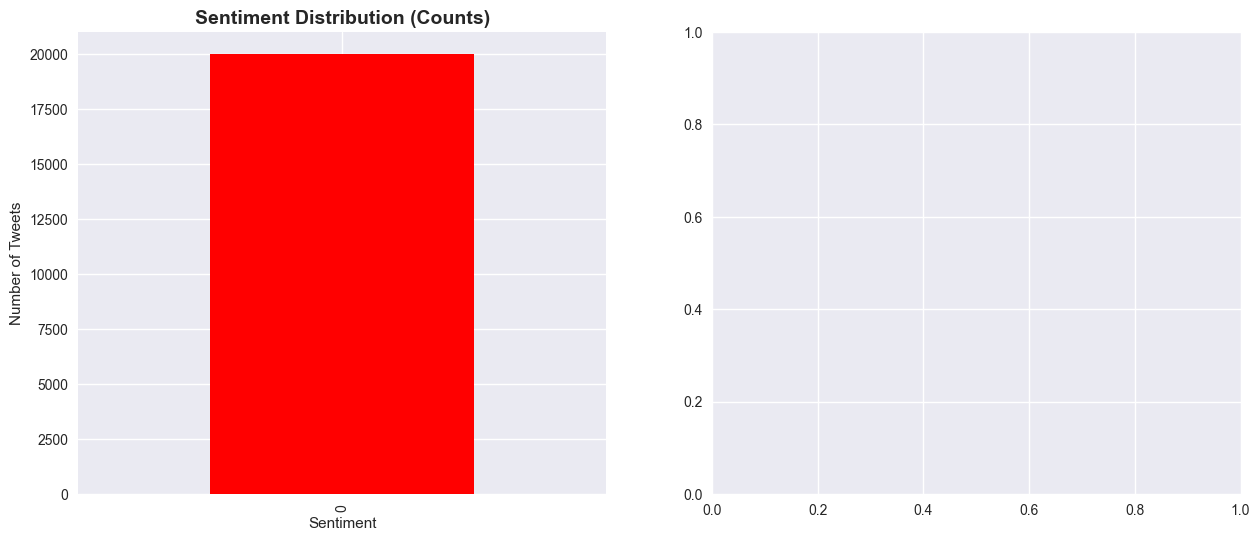

In [6]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
sentiment_counts.plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Sentiment Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of Tweets')
axes[0].set_xticklabels(['Negative', 'Positive'], rotation=0)
axes[0].tick_params(axis='x', labelsize=12)

# Pie chart
colors = ['#ff6b6b', '#51cf66']
wedges, texts, autotexts = axes[1].pie(sentiment_percentages.values, 
                                       labels=sentiment_percentages.index,
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
axes[1].set_title('Sentiment Distribution (Percentages)', fontsize=14, fontweight='bold')

# Enhance pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.savefig('../reports/figures/sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Text length analysis
print("=== TEXT LENGTH ANALYSIS ===")

# Calculate text lengths
df['text_length'] = df['tweet_text'].str.len()
df['word_count'] = df['tweet_text'].str.split().str.len()

# Basic statistics
print("Character length statistics:")
print(df['text_length'].describe())

print("\nWord count statistics:")
print(df['word_count'].describe())

# Check for empty tweets
empty_tweets = df[df['tweet_text'].str.strip() == ''].shape[0]
print(f"\nEmpty tweets: {empty_tweets}")

# Check for very short tweets
very_short = df[df['word_count'] <= 2].shape[0]
print(f"Very short tweets (≤2 words): {very_short}")


In [9]:
# Twitter-specific elements analysis
print("=== TWITTER-SPECIFIC ELEMENTS ===")

# Count various Twitter elements
df['has_hashtag'] = df['tweet_text'].str.contains(r'#', na=False)
df['has_mention'] = df['tweet_text'].str.contains(r'@', na=False)
df['has_url'] = df['tweet_text'].str.contains(r'http', na=False)
df['has_emoji'] = df['tweet_text'].str.contains(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', na=False)

# Count occurrences
hashtag_count = df['has_hashtag'].sum()
mention_count = df['has_mention'].sum()
url_count = df['has_url'].sum()
emoji_count = df['has_emoji'].sum()

print(f"Tweets with hashtags: {hashtag_count:,} ({hashtag_count/len(df)*100:.2f}%)")
print(f"Tweets with mentions: {mention_count:,} ({mention_count/len(df)*100:.2f}%)")
print(f"Tweets with URLs: {url_count:,} ({url_count/len(df)*100:.2f}%)")
print(f"Tweets with emojis: {emoji_count:,} ({emoji_count/len(df)*100:.2f}%)")


=== TWITTER-SPECIFIC ELEMENTS ===
Tweets with hashtags: 381 (1.91%)
Tweets with mentions: 7,221 (36.10%)
Tweets with URLs: 496 (2.48%)
Tweets with emojis: 0 (0.00%)


In [10]:
# Sample tweets analysis
print("=== SAMPLE TWEETS ANALYSIS ===")

# Show sample tweets for each sentiment
print("\nSample Negative Tweets:")
negative_samples = df[df['sentiment'] == 0]['tweet_text'].head(5)
for i, tweet in enumerate(negative_samples, 1):
    print(f"{i}. {tweet}")

print("\nSample Positive Tweets:")
positive_samples = df[df['sentiment'] == 4]['tweet_text'].head(5)
for i, tweet in enumerate(positive_samples, 1):
    print(f"{i}. {tweet}")


=== SAMPLE TWEETS ANALYSIS ===

Sample Negative Tweets:
1. @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
2. is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
3. @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
4. my whole body feels itchy and like its on fire 
5. @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 

Sample Positive Tweets:


In [11]:
# Summary statistics and insights
print("=== EXPLORATORY DATA ANALYSIS SUMMARY ===")
print(f"\n📊 Dataset Overview:")
print(f"   • Total tweets: {len(df):,}")
print(f"   • Negative tweets: {sentiment_counts[0]:,} ({sentiment_percentages['Negative']:.1f}%)")
print(f"   • Positive tweets: {sentiment_counts[4]:,} ({sentiment_percentages['Positive']:.1f}%)")

print(f"\n📝 Text Characteristics:")
print(f"   • Average character length: {df['text_length'].mean():.1f}")
print(f"   • Average word count: {df['word_count'].mean():.1f}")
print(f"   • Tweets with hashtags: {hashtag_count/len(df)*100:.1f}%")
print(f"   • Tweets with mentions: {mention_count/len(df)*100:.1f}%")
print(f"   • Tweets with URLs: {url_count/len(df)*100:.1f}%")

print(f"\n✅ Next Steps:")
print(f"   • Proceed to preprocessing notebook for text cleaning")
print(f"   • Implement feature extraction (TF-IDF, Word2Vec, GloVe)")
print(f"   • Address class imbalance if needed")
print(f"   • Prepare data for model training")


=== EXPLORATORY DATA ANALYSIS SUMMARY ===

📊 Dataset Overview:
   • Total tweets: 20,000
   • Negative tweets: 20,000 (100.0%)


KeyError: 4